In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv(r"C:\Users\Vaishali Senthil\Downloads\renamed_combined_data.csv")

### Data Cleaning

In [4]:
# There were three readings each for diastolic and systiolic bp. taking average to make a new variable. 
df['Avg_Diastolic_BP'] = df[['Diastolic_BP_1', 'Diastolic_BP_2', 'Diastolic_BP_3']].mean(axis=1)
df['Avg_Systolic_BP'] = df[['Systolic_BP_1', 'Systolic_BP_2', 'Systolic_BP_3']].mean(axis=1)
df.drop(columns=['Diastolic_BP_1', 'Diastolic_BP_2', 'Diastolic_BP_3',
                 'Systolic_BP_1', 'Systolic_BP_2', 'Systolic_BP_3'], inplace=True)

In [5]:
# Dropping variables that are not relevant. 
df.drop(columns=['Household_Reference_Gender', 'Household_Reference_Marital_Status', 'Household_Reference_Education', 'Household_Reference_Age', 'Exam_Weight', 'Interview_Weight'], inplace=True)
df.drop(columns=['Children_Under_5', 'Children_Aged_6_17', 'Adults_Aged_60_Plus', 'Age_Under_24_Months', 'Age_19_Or_Less',], inplace=True)

In [6]:
#Only checking for adults since care for children is different
df['Participant_Age'] = df['Participant_Age'].astype(int)
df = df[df['Participant_Age'] >= 20]

In [7]:
# Checking for missing values
var1 = df.isnull().sum()
var1_percent = (var1 / len(df)) * 100
miss = pd.DataFrame({'Missing': var1, 'Percentage': var1_percent})
print(miss.sort_values(by='Percentage', ascending=False))

                                  Missing  Percentage
Highest_Education_Level              5569  100.000000
Urine_Nicotine                       5131   92.135033
Pregnancy_Status                     4459   80.068235
Total_Nicotine_Equivalents           3898   69.994613
Age_High_BP_Onset                    3450   61.950081
Insulin                              3183   57.155683
Fasting_Glucose                      3134   56.275813
Fasting_Subsample_Weight             3028   54.372419
Income_to_Poverty_Ratio               791   14.203627
Total_Cholesterol                     632   11.348537
Avg_Systolic_BP                       573   10.289100
Avg_Diastolic_BP                      573   10.289100
Pulse_Status                          552    9.912013
Glycohemoglobin                       551    9.894056
BMI                                   394    7.074879
Height                                384    6.895313
Weight                                384    6.895313
Household_Income            

In [8]:
print(f"Number of Rows: {df.shape[0]}, Number of Columns: {df.shape[1]}")


Number of Rows: 5569, Number of Columns: 30


In [9]:
# Removing variables with high missing percentage , percentage greater than 50. 
df.drop(columns=['Urine_Nicotine', 'Pregnancy_Status', 'Age_High_BP_Onset', 'Highest_Education_Level', 'Total_Nicotine_Equivalents', 'Insulin', 'Fasting_Glucose', 'Fasting_Subsample_Weight', 'Respondent_ID'   ], inplace=True)

In [18]:
print(f"Number of Rows: {df.shape[0]}, Number of Columns: {df.shape[1]}")

var1 = df.isnull().sum()
var1_percent = (var1 / len(df)) * 100
miss = pd.DataFrame({'Missing': var1, 'Percentage': var1_percent})
print(miss.sort_values(by='Percentage', ascending=False))

Number of Rows: 5569, Number of Columns: 21
                                  Missing  Percentage
Income_to_Poverty_Ratio               791   14.203627
Total_Cholesterol                     632   11.348537
Avg_Systolic_BP                       573   10.289100
Avg_Diastolic_BP                      573   10.289100
Pulse_Status                          552    9.912013
Glycohemoglobin                       551    9.894056
BMI                                   394    7.074879
Height                                384    6.895313
Weight                                384    6.895313
Household_Income                      326    5.853834
US_Citizen                              3    0.053870
Doctor_Reported_High_Cholesterol        0    0.000000
Doctor_Approved_High_BP                 0    0.000000
Birth_Country                           0    0.000000
Race_Category_1                         0    0.000000
Participant_Age                         0    0.000000
Participant_Gender                    

In [20]:
df = df.dropna(subset=['Income_to_Poverty_Ratio'])

In [22]:
# removing race_category 1 since it is the same as race category 3 
df.drop(columns=['Race_Category_1'], inplace=True)

In [24]:
print(f"Number of Rows: {df.shape[0]}, Number of Columns: {df.shape[1]}")

var1 = df.isnull().sum()
var1_percent = (var1 / len(df)) * 100
miss = pd.DataFrame({'Missing': var1, 'Percentage': var1_percent})
print(miss.sort_values(by='Percentage', ascending=False))

Number of Rows: 4778, Number of Columns: 20
                                  Missing  Percentage
Total_Cholesterol                     477    9.983257
Avg_Systolic_BP                       415    8.685643
Avg_Diastolic_BP                      415    8.685643
Glycohemoglobin                       413    8.643784
Pulse_Status                          400    8.371704
BMI                                   287    6.006697
Weight                                279    5.839263
Height                                277    5.797405
Household_Income                       13    0.272080
US_Citizen                              1    0.020929
Income_to_Poverty_Ratio                 0    0.000000
Participant_Gender                      0    0.000000
Participant_Age                         0    0.000000
Race_Category_3                         0    0.000000
Marital_Status                          0    0.000000
Household_Size                          0    0.000000
Doctor_Approved_High_BP               

In [26]:
# replacing categorical income values with the average income it corresponds to 
income_mapping = {
    1: 2500, 2: 7500, 3: 12500, 4: 17500, 5: 22500,
    6: 30000, 7: 40000, 8: 50000, 9: 60000, 10: 70000,
    12: 35000, 13: 10000, 14: 87500, 15: 100000
}
df['Household_Income'] = df['Household_Income'].replace(income_mapping)

# Remove rows where Household_Income is 77 or 99 as these numbers indicate missing or unknown values.
df = df[~df['Household_Income'].isin([77, 99])]

In [28]:
# Doing the same for all other categorical variables 
us_citizen_mapping = {1: 'Citizen', 2: 'Not a US Citizen', 7: 'Refused', 9: 'Don’t Know'}
doctor_reported_cholesterol_mapping = {1: 'Yes', 2: 'No', 7: 'Refused', 9: 'Don’t Know'}
doctor_approved_bp_mapping = {1: 'Yes', 2: 'No', 7: 'Refused', 9: 'Don’t Know'}
birth_country_mapping = {1: 'Born in US', 2: 'Other Country', 7: 'Refused', 9: 'Don’t Know'}
pulse_status_mapping = {1: 'Regular', 2: 'Irregular'}
participant_gender_mapping = {1: 'Male', 2: 'Female'}
marital_status_mapping = {
    1: 'Married', 2: 'Widowed', 3: 'Divorced', 4: 'Separated', 5: 'Never Married', 
    6: 'Living with Partner', 77: 'Refused', 99: 'Don’t Know'
}
highest_degree_obtained_mapping = {
    1: 'Less than 9th Grade', 2: '9-11th Grade', 3: 'High School Graduate',
    4: 'Some College/AA Degree', 5: 'College Graduate or Above', 7: 'Refused', 9: 'Don’t Know'
}
race_category_3_mapping = {
    1: 'Mexican American', 2: 'Other Hispanic', 3: 'White', 4: 'Black', 
    6: 'Asian', 7: 'Multiracial'
}
df['US_Citizen'] = df['US_Citizen'].map(us_citizen_mapping)
df['Pulse_Status'] = df['Pulse_Status'].map(pulse_status_mapping)
df['Doctor_Reported_High_Cholesterol'] = df['Doctor_Reported_High_Cholesterol'].map(doctor_reported_cholesterol_mapping)
df['Doctor_Approved_High_BP'] = df['Doctor_Approved_High_BP'].map(doctor_approved_bp_mapping)
df['Birth_Country'] = df['Birth_Country'].map(birth_country_mapping)
df['Participant_Gender'] = df['Participant_Gender'].map(participant_gender_mapping)
df['Marital_Status'] = df['Marital_Status'].map(marital_status_mapping)
df['Highest_Degree_Obtained'] = df['Highest_Degree_Obtained'].map(highest_degree_obtained_mapping)
df['Race_Category_3'] = df['Race_Category_3'].map(race_category_3_mapping)

In [30]:
categorical = ['Pulse_Status', 'US_Citizen', 'Doctor_Reported_High_Cholesterol', 
                    'Doctor_Approved_High_BP', 'Marital_Status', 'Highest_Degree_Obtained', 
                    'Race_Category_3']

In [32]:
#One hot encoding after handeling nan and inf values  : 
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)
df_encoded = pd.get_dummies(df, columns=categorical, drop_first=True)
print(df_encoded.shape)
df_encoded.head()

(4759, 41)


,Birth_Country,Household_Size,Income_to_Poverty_Ratio,Household_Income,Participant_Gender,Participant_Age,BMI,Height,Weight,Total_Cholesterol,...,Highest_Degree_Obtained_Don’t Know,Highest_Degree_Obtained_High School Graduate,Highest_Degree_Obtained_Less than 9th Grade,Highest_Degree_Obtained_Refused,Highest_Degree_Obtained_Some College/AA Degree,Race_Category_3_Black,Race_Category_3_Mexican American,Race_Category_3_Multiracial,Race_Category_3_Other Hispanic,Race_Category_3_White
2,Born in US,1,0.82,12500.0,Female,66,31.7,158.3,79.5,157.0,...,False,False,False,False,False,True,False,False,False,False
5,Other Country,2,1.63,30000.0,Female,66,23.7,150.2,53.5,209.0,...,False,False,True,False,False,False,False,False,False,False
6,Born in US,1,0.41,7500.0,Female,75,38.9,151.1,88.8,176.0,...,False,False,False,False,True,True,False,False,False,False
8,Other Country,3,5.00,100000.0,Male,56,21.3,170.6,62.1,238.0,...,False,False,False,False,False,False,False,False,False,False
10,Born in US,1,2.65,30000.0,Male,67,23.5,178.6,74.9,184.0,...,False,True,False,False,False,False,False,False,False,True


In [34]:

df_encoded = pd.get_dummies(df_encoded, columns=['Birth_Country'], drop_first=True)

df_encoded = pd.get_dummies(df_encoded, columns=['Participant_Gender'], drop_first=True)


In [36]:
df_encoded.columns 

Index(['Household_Size', 'Income_to_Poverty_Ratio', 'Household_Income',
       'Participant_Age', 'BMI', 'Height', 'Weight', 'Total_Cholesterol',
       'Glycohemoglobin', 'Avg_Diastolic_BP', 'Avg_Systolic_BP',
       'Pulse_Status_Irregular', 'Pulse_Status_Regular', 'US_Citizen_Citizen',
       'US_Citizen_Don’t Know', 'US_Citizen_Not a US Citizen',
       'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No',
       'Doctor_Reported_High_Cholesterol_Refused',
       'Doctor_Reported_High_Cholesterol_Yes', 'Doctor_Approved_High_BP_No',
       'Doctor_Approved_High_BP_Yes', 'Marital_Status_Living with Partner',
       'Marital_Status_Married', 'Marital_Status_Never Married',
       'Marital_Status_Refused', 'Marital_Status_Separated',
       'Marital_Status_Widowed',
       'Highest_Degree_Obtained_College Graduate or Above',
       'Highest_Degree_Obtained_Don’t Know',
       'Highest_Degree_Obtained_High School Graduate',
       'Highest_Degree_Obtained_Less than 9th Grade',
  

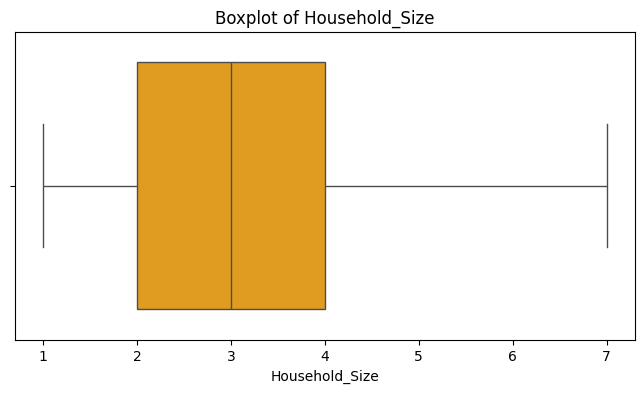

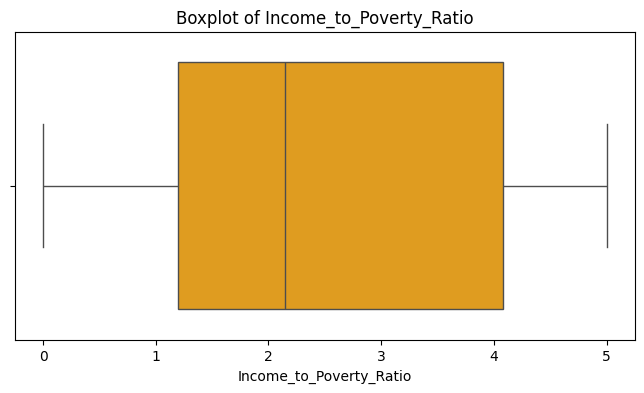

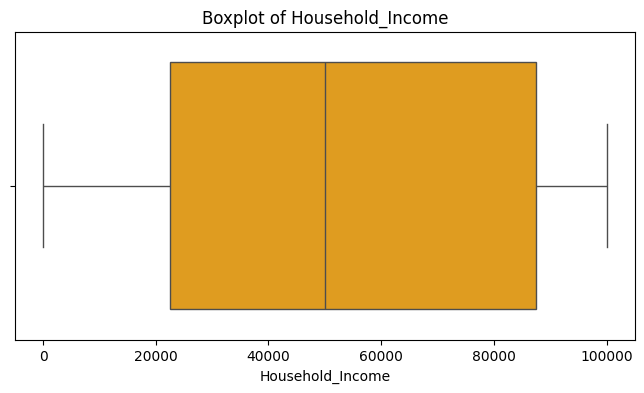

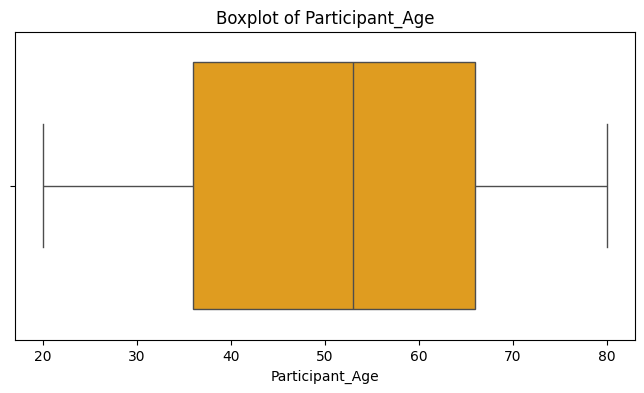

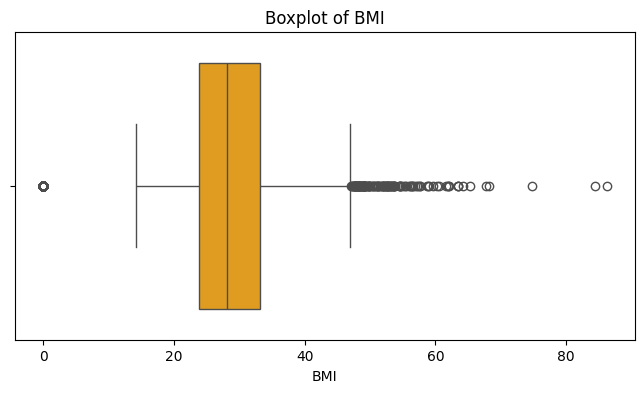

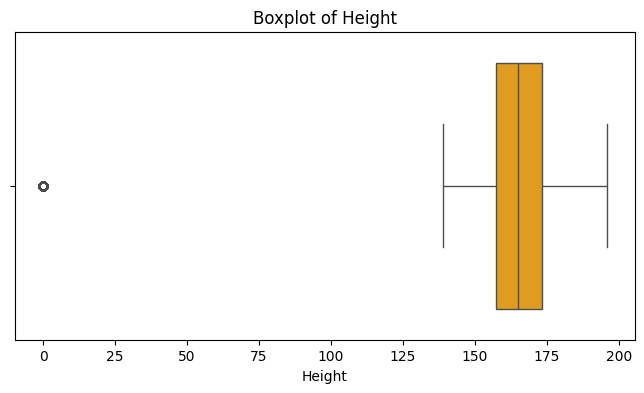

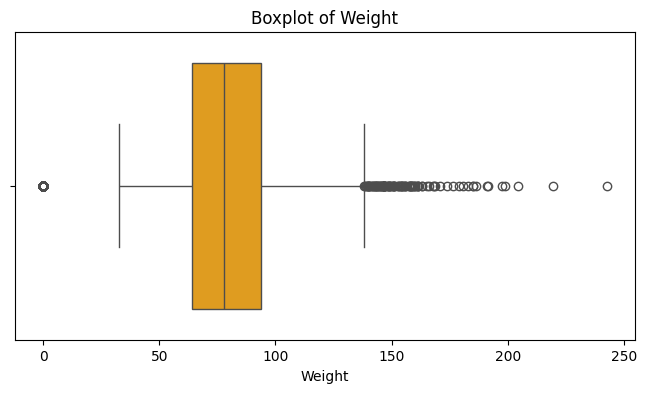

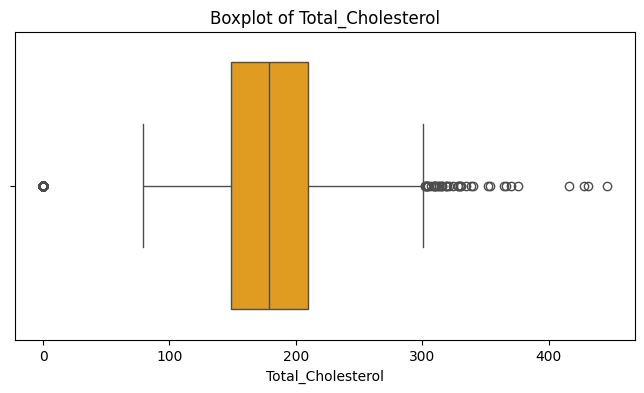

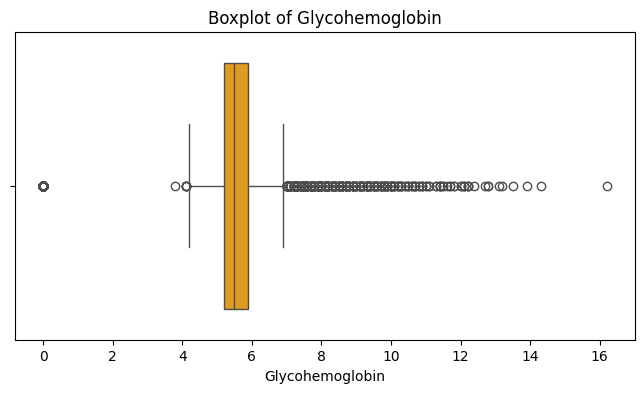

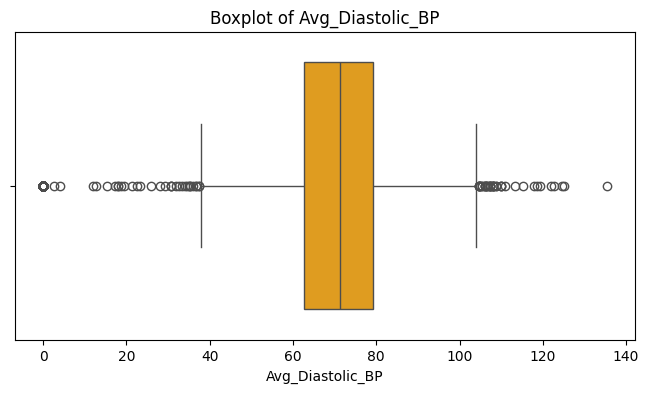

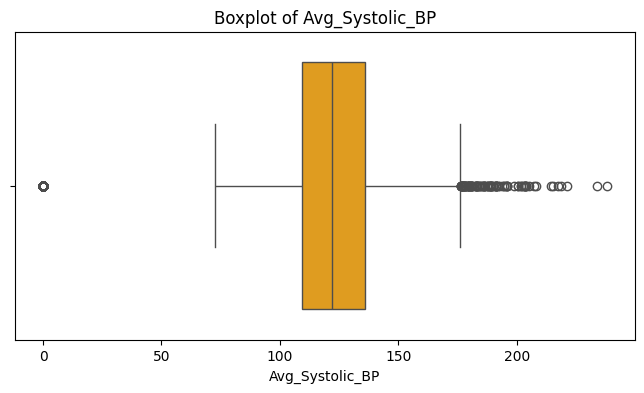

Removed outliers from Household_Size. Rows before: 4759, after: 4759.
Removed outliers from Income_to_Poverty_Ratio. Rows before: 4759, after: 4759.
Removed outliers from Household_Income. Rows before: 4759, after: 4759.
Removed outliers from Participant_Age. Rows before: 4759, after: 4759.
Removed outliers from BMI. Rows before: 4759, after: 4759.
Removed outliers from Height. Rows before: 4759, after: 4759.
Removed outliers from Weight. Rows before: 4759, after: 4759.
Removed outliers from Total_Cholesterol. Rows before: 4759, after: 4759.
Removed outliers from Glycohemoglobin. Rows before: 4759, after: 4759.
Removed outliers from Avg_Diastolic_BP. Rows before: 4759, after: 4759.
Removed outliers from Avg_Systolic_BP. Rows before: 4759, after: 4759.


In [38]:
#Removing outliers for numeric variables
numeric = ['Household_Size', 'Income_to_Poverty_Ratio', 'Household_Income',
       'Participant_Age', 'BMI', 'Height', 'Weight', 'Total_Cholesterol',
       'Glycohemoglobin', 'Avg_Diastolic_BP', 'Avg_Systolic_BP']

for col in numeric:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_encoded[col], color='orange')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

def remove_outliers(df_encoded, column):
    Q1 = df_encoded[column].quantile(0.25)
    Q3 = df_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_encoded[(df_encoded[column] >= lower_bound) & (df_encoded[column] <= upper_bound)]

for col in numeric:
    original_size = len(df)
    df_encoded = remove_outliers(df_encoded, col)
    print(f"Removed outliers from {col}. Rows before: {original_size}, after: {len(df)}.")

In [39]:
var1 = df_encoded.isnull().sum()
var1_percent = (var1 / len(df_encoded)) * 100
miss = pd.DataFrame({'Missing': var1, 'Percentage': var1_percent})
print(miss.sort_values(by='Percentage', ascending=False))

                                                   Missing  Percentage
Household_Size                                           0         0.0
Highest_Degree_Obtained_Less than 9th Grade              0         0.0
Marital_Status_Married                                   0         0.0
Marital_Status_Never Married                             0         0.0
Marital_Status_Refused                                   0         0.0
Marital_Status_Separated                                 0         0.0
Marital_Status_Widowed                                   0         0.0
Highest_Degree_Obtained_College Graduate or Above        0         0.0
Highest_Degree_Obtained_Don’t Know                       0         0.0
Highest_Degree_Obtained_High School Graduate             0         0.0
Highest_Degree_Obtained_Refused                          0         0.0
Income_to_Poverty_Ratio                                  0         0.0
Highest_Degree_Obtained_Some College/AA Degree           0         0.0
Race_C

### LR TO PREDICT CHOLESTROL

C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Average TPR across folds: 0.6853
Average Accuracy across folds: 0.7018
Average ROC AUC across folds: 0.7658


C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Optimal Threshold (from CV): 0.4949
Accuracy on Test Set at Optimal Threshold: 0.7265
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.7385
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.2794
Confusion Matrix on Test Set at Optimal Threshold:
[[325 126]
 [ 57 161]]
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.72      0.78       451
        True       0.56      0.74      0.64       218

    accuracy                           0.73       669
   macro avg       0.71      0.73      0.71       669
weighted avg       0.76      0.73      0.73       669

ROC AUC Score on Test Set: 0.7839


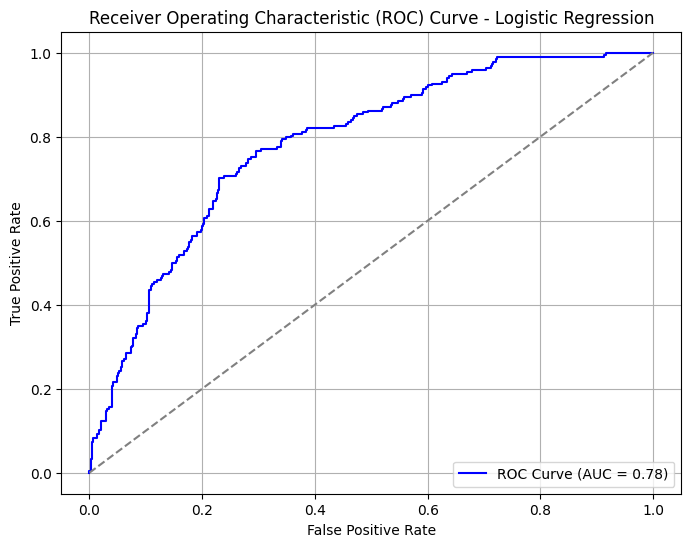

In [43]:
target = 'Doctor_Reported_High_Cholesterol_Yes'

features = df_encoded.drop(columns=[target , 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic','Doctor_Reported_High_Cholesterol_No',
       'Doctor_Reported_High_Cholesterol_Refused', 'BMI'  ]) 
X = features
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')

thresholds = np.linspace(0, 1, 100)
tpr_values = []
accuracy_values = []
roc_auc_values = []
y_prob_baseline = model_lr.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    model_lr.fit(X_train_cv, y_train_cv)
    
    y_prob_cv = model_lr.predict_proba(X_val_cv)[:, 1]
    
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  
    best_tpr = 0
    best_fpr = 1 
    
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  
        fpr = fp / (fp + tn)  
    
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))

avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)

print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")

model_lr.fit(X_train, y_train)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

y_pred_optimal = (y_prob_lr >= best_threshold).astype(int)

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)

print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_lr):.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Feature Impact Analysis:
                                          feature  coefficient direction
                      Doctor_Approved_High_BP_Yes     0.803269 Increases
                          Participant_Gender_Male     0.303345 Increases
                                  Glycohemoglobin     0.251375 Increases
                           Marital_Status_Married     0.243594 Increases
                                   Household_Size    -0.228138 Decreases
   Highest_Degree_Obtained_Some College/AA Degree     0.200135 Increases
                         Birth_Country_Born in US    -0.181475 Decreases
                            Race_Category_3_Black    -0.170763 Decreases
                      Birth_Country_Other Country     0.157838 Increases
Highest_Degree_Obtained_College Graduate or Above    -0.120326 Decreases
                      Race_Category_3_Multiracial    -0.105692 Decreases
                     Marital_Status_Never Married    -0.098833 Decreases
                         

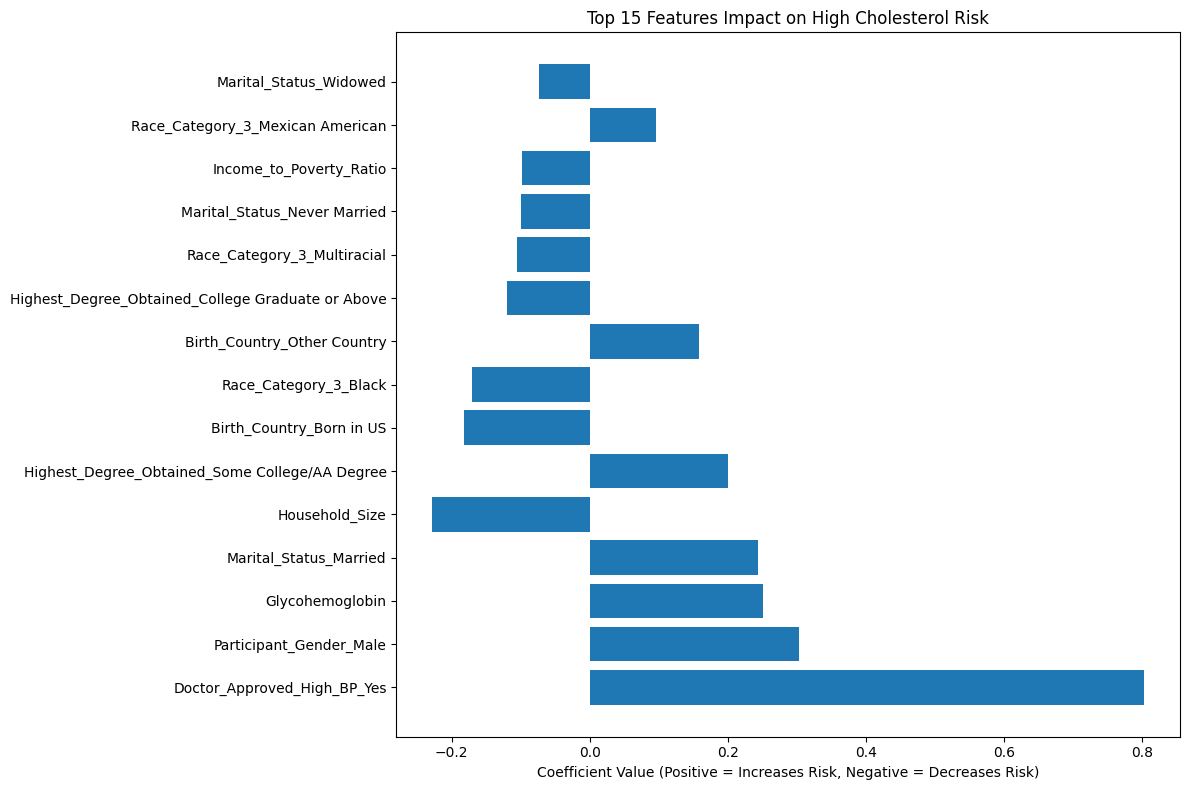

In [45]:
# Analysis of features and their importance 
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'coefficient': model_lr.coef_[0]
})


feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)


feature_importance['direction'] = ['Increases' if coef > 0 else 'Decreases' for coef in feature_importance['coefficient']]


print("\nFeature Impact Analysis:")
print("=" * 80)
print(feature_importance[['feature', 'coefficient', 'direction']].head(15).to_string(index=False))


plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value (Positive = Increases Risk, Negative = Decreases Risk)')
plt.title('Top 15 Features Impact on High Cholesterol Risk')
plt.tight_layout()
plt.show()

### CART TO PREDICT CH

Average TPR across folds: 0.0000
Average Accuracy across folds: 1.0000
Average ROC AUC across folds: 0.5983
Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.6532
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.4679
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.2572
Confusion Matrix on Test Set at Optimal Threshold:
[[335 116]
 [116 102]]
Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.74      0.74       451
        True       0.47      0.47      0.47       218

    accuracy                           0.65       669
   macro avg       0.61      0.61      0.61       669
weighted avg       0.65      0.65      0.65       669

ROC AUC Score on Test Set: 0.6053


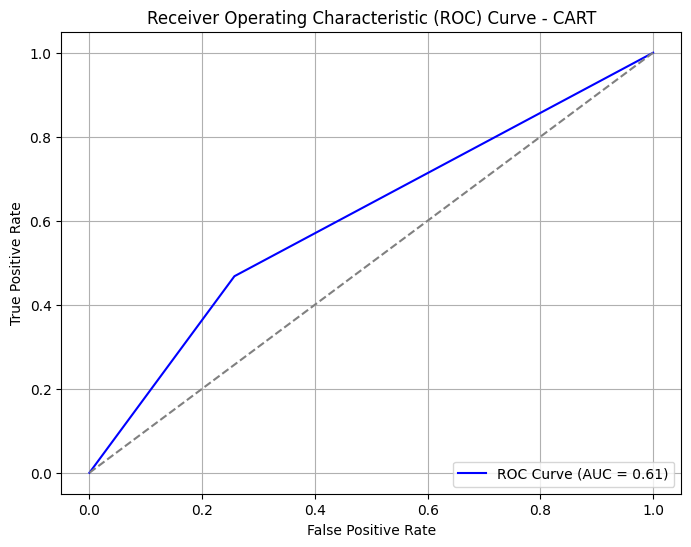

In [48]:
model_cart = DecisionTreeClassifier(random_state=42, class_weight='balanced')

thresholds = np.linspace(0, 1, 100)

tpr_values = []
accuracy_values = []
roc_auc_values = []

y_prob_baseline = model_cart.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    model_cart.fit(X_train_cv, y_train_cv)
    
    
    y_prob_cv = model_cart.predict_proba(X_val_cv)[:, 1]
    
   
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  
    best_tpr = 0
    best_fpr = 1  
    
    
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
       
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
    
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

   
    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)


print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")

model_cart.fit(X_train, y_train)
y_prob_cart = model_cart.predict_proba(X_test)[:, 1]

y_pred_optimal = (y_prob_cart >= best_threshold).astype(int)

conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)

print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_cart):.4f}")

fpr, tpr, _ = roc_curve(y_test, y_prob_cart)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_cart):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - CART')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### xgboost to predixt ch

Average TPR across folds: 0.0000
Average Accuracy across folds: 0.9996
Average ROC AUC across folds: 0.7294
Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.7235
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.5046
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.1707
Confusion Matrix on Test Set at Optimal Threshold:
[[374  77]
 [108 110]]
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.83      0.80       451
        True       0.59      0.50      0.54       218

    accuracy                           0.72       669
   macro avg       0.68      0.67      0.67       669
weighted avg       0.71      0.72      0.72       669

ROC AUC Score on Test Set: 0.7619


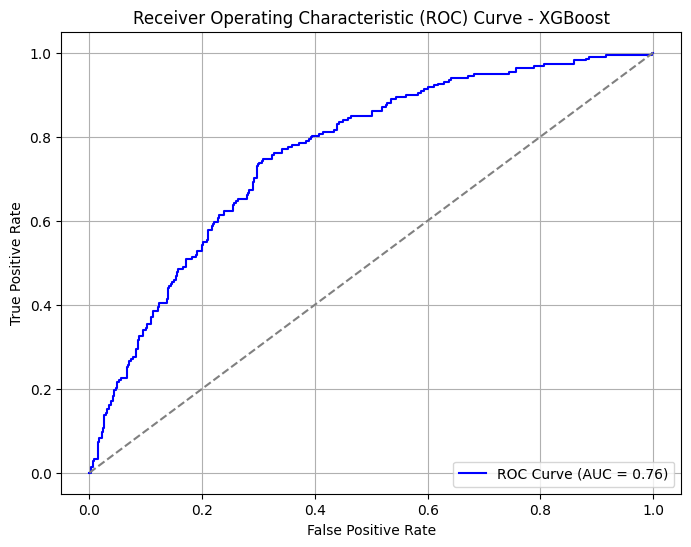

In [51]:
model_xgb = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=1, random_state=42)


thresholds = np.linspace(0, 1, 100)

tpr_values = []
accuracy_values = []
roc_auc_values = []


model_xgb.fit(X_train, y_train)
y_prob_baseline = model_xgb.predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    

    model_xgb.fit(X_train_cv, y_train_cv)
    
    y_prob_cv = model_xgb.predict_proba(X_val_cv)[:, 1]
    
    
    best_threshold = 0.5
    best_accuracy = baseline_accuracy 
    best_tpr = 0
    best_fpr = 1  
  
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
       
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
        
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))

avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)


print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")


model_xgb.fit(X_train, y_train)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_xgb >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)


print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_xgb):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### random forest to predict ch

Average TPR across folds: 0.0000
Average Accuracy across folds: 1.0000
Average ROC AUC across folds: 0.7547
Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.7384
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.4266
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.1109
Confusion Matrix on Test Set at Optimal Threshold:
[[401  50]
 [125  93]]
Classification Report:
              precision    recall  f1-score   support

       False       0.76      0.89      0.82       451
        True       0.65      0.43      0.52       218

    accuracy                           0.74       669
   macro avg       0.71      0.66      0.67       669
weighted avg       0.73      0.74      0.72       669

ROC AUC Score on Test Set: 0.7788


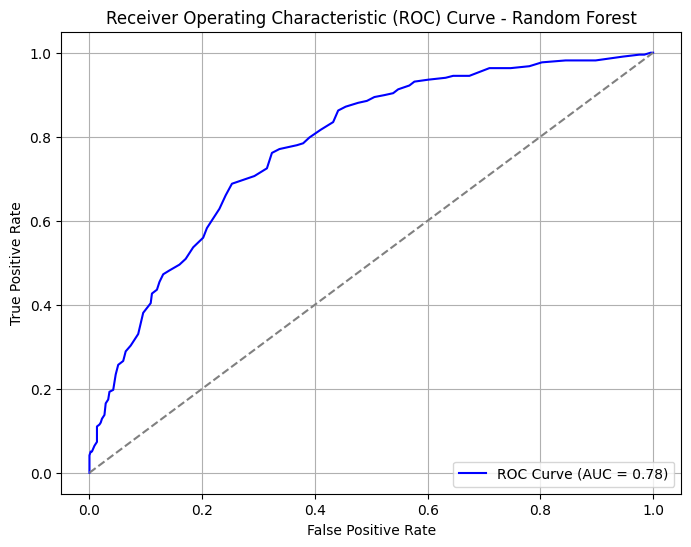

In [54]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

thresholds = np.linspace(0, 1, 100)

tpr_values = []
accuracy_values = []
roc_auc_values = []


y_prob_baseline = model_rf.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    model_rf.fit(X_train_cv, y_train_cv)
    

    y_prob_cv = model_rf.predict_proba(X_val_cv)[:, 1]
    
    
    best_threshold = 0.5
    best_accuracy = baseline_accuracy 
    best_tpr = 0
    best_fpr = 1  
    
   
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
       
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
        
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    
    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)


print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")


model_rf.fit(X_train, y_train)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_rf >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)


print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_rf):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_rf)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### COMBINED ROC AUC FOR CHOLESTEROL PREDICTION

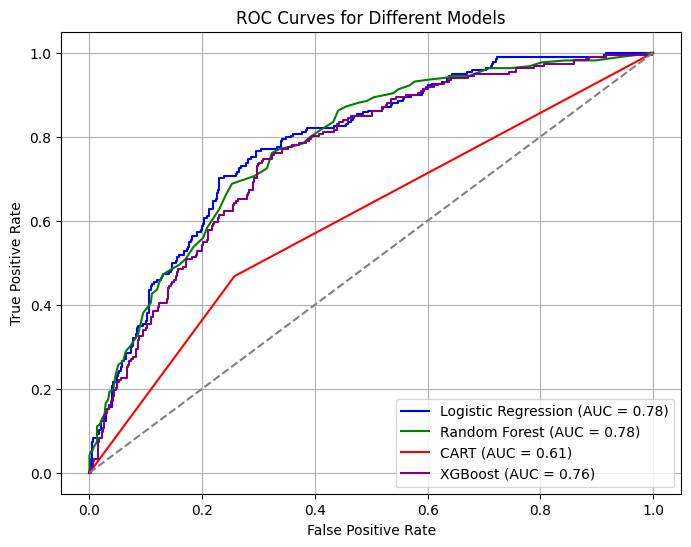

In [56]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_cart, tpr_cart, _ = roc_curve(y_test, y_prob_cart)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)


roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_cart = roc_auc_score(y_test, y_prob_cart)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_cart, tpr_cart, color='red', label=f'CART (AUC = {roc_auc_cart:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='purple', label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')


plt.title('ROC Curves for Different Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)


plt.show()


### LR TO PRIDICT HIGH BP

C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Average TPR across folds: 0.4095
Average Accuracy across folds: 0.7539
Average ROC AUC across folds: 0.7972
Optimal Threshold (from CV): 0.3333
Accuracy on Test Set at Optimal Threshold: 0.7220
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.7381
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.2854
Confusion Matrix on Test Set at Optimal Threshold:
[[328 131]
 [ 55 155]]
Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.71      0.78       459
        True       0.54      0.74      0.62       210

    accuracy                           0.72       669
   macro avg       0.70      0.73      0.70       669
weighted avg       0.76      0.72      0.73       669

ROC AUC Score on Test Set: 0.8013


C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


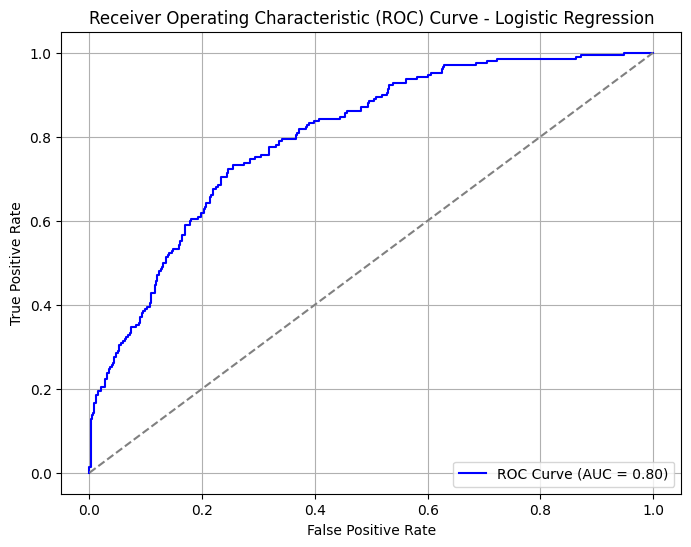

In [58]:
target = 'Doctor_Approved_High_BP_Yes'


features = df_encoded.drop(columns=[target, 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic', 'Avg_Diastolic_BP', 'Avg_Systolic_BP' ])  # Dropping the target and unwanted columns


features = pd.get_dummies(features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


thresholds = np.linspace(0, 1, 100)
tpr_values = []
accuracy_values = []
roc_auc_values = []


model_lr = LogisticRegression(max_iter=1000)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


y_prob_baseline = model_lr.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    model_lr.fit(X_train_cv, y_train_cv)
    
   
    y_prob_cv = model_lr.predict_proba(X_val_cv)[:, 1]
    
   
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  # Ensure baseline accuracy
    best_tpr = 0
    best_fpr = 1  # Worst possible, to be minimized
    
   
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
        
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
     
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)

print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")


model_lr.fit(X_train, y_train)
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_lr >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)


print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_lr):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_lr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Top Features by Importance:
                                           Feature  Coefficient  \
14            Doctor_Reported_High_Cholesterol_Yes     0.874953   
7                                  Glycohemoglobin     0.462307   
26                Race_Category_3_Mexican American    -0.424064   
25                           Race_Category_3_Black     0.380765   
28                           Race_Category_3_White    -0.163350   
24  Highest_Degree_Obtained_Some College/AA Degree     0.163089   
31                         Participant_Gender_Male     0.128671   
16                    Marital_Status_Never Married    -0.090512   
12                     US_Citizen_Not a US Citizen    -0.081385   
1                          Income_to_Poverty_Ratio     0.078253   

    Absolute Coefficient  
14              0.874953  
7               0.462307  
26              0.424064  
25              0.380765  
28              0.163350  
24              0.163089  
31              0.128671  
16              0.

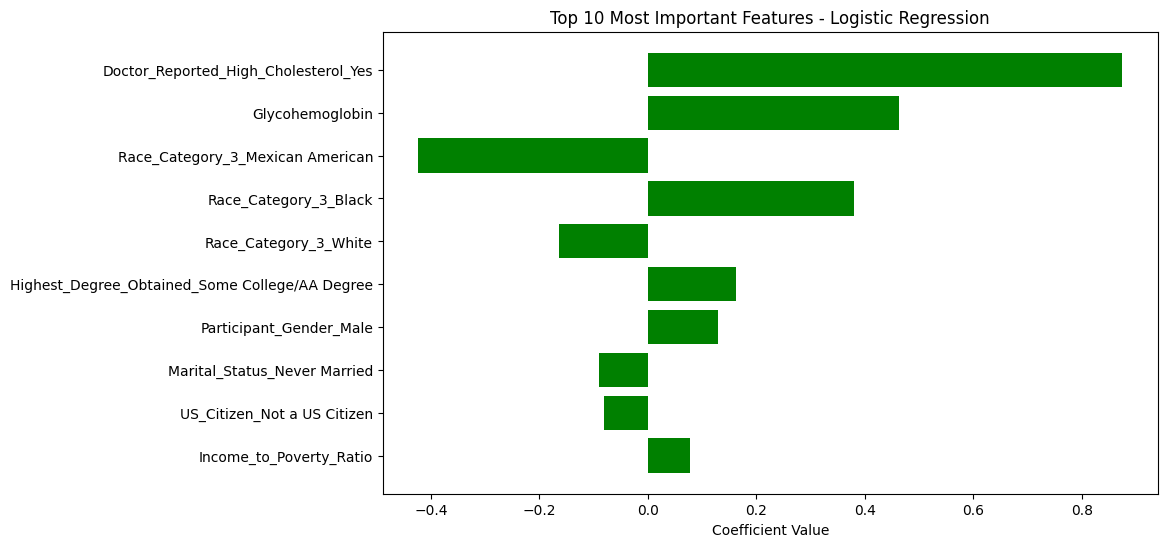

In [59]:
# Feature importance analysis 
feature_importance = model_lr.coef_[0]
feature_names = features.columns


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': feature_importance,
    'Absolute Coefficient': np.abs(feature_importance),
})


importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)


print("Top Features by Importance:")
print(importance_df.head(10))


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Coefficient'][:10], color='green')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Important Features - Logistic Regression')
plt.gca().invert_yaxis()  
plt.show()


### RF TO PREDICT HIGH BP

Average TPR across folds: 0.0000
Average Accuracy across folds: 1.0000
Average ROC AUC across folds: 0.7724
Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.7444
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.4952
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.1416
Confusion Matrix on Test Set at Optimal Threshold:
[[394  65]
 [106 104]]
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.86      0.82       459
        True       0.62      0.50      0.55       210

    accuracy                           0.74       669
   macro avg       0.70      0.68      0.69       669
weighted avg       0.73      0.74      0.74       669

ROC AUC Score on Test Set: 0.7956


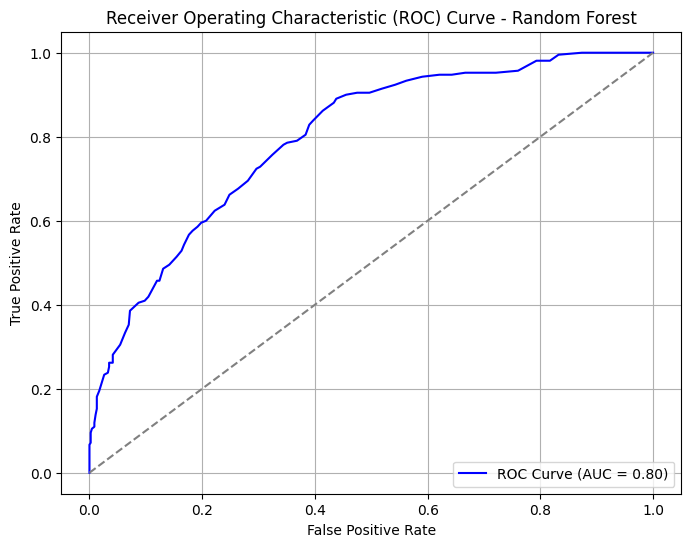

In [61]:
target = 'Doctor_Approved_High_BP_Yes'


features = df_encoded.drop(columns=[target, 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic', 'Avg_Diastolic_BP', 'Avg_Systolic_BP' ])  


features = pd.get_dummies(features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


thresholds = np.linspace(0, 1, 100)
tpr_values = []
accuracy_values = []
roc_auc_values = []


model_rf = RandomForestClassifier(n_estimators=100, random_state=42)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_prob_baseline = model_rf.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    model_rf.fit(X_train_cv, y_train_cv)
    
   
    y_prob_cv = model_rf.predict_proba(X_val_cv)[:, 1]
    
   
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  # Ensure baseline accuracy
    best_tpr = 0
    best_fpr = 1  # Worst possible, to be minimized
    
   
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
        
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
        
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

   
    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)


print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")


model_rf.fit(X_train, y_train)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_rf >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)


print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_rf):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### CART TO PREDICT HIGH BP

Average TPR across folds: 0.0000
Average Accuracy across folds: 1.0000
Average ROC AUC across folds: 0.6240
Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.6756
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.5476
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.2658
Confusion Matrix on Test Set at Optimal Threshold:
[[337 122]
 [ 95 115]]
Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.73      0.76       459
        True       0.49      0.55      0.51       210

    accuracy                           0.68       669
   macro avg       0.63      0.64      0.64       669
weighted avg       0.69      0.68      0.68       669

ROC AUC Score on Test Set: 0.6409


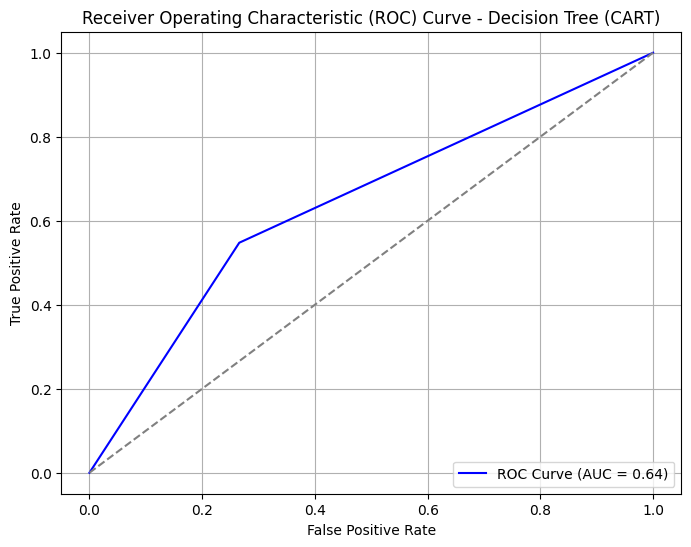

In [63]:
target = 'Doctor_Approved_High_BP_Yes' 

features = df_encoded.drop(columns=[target, 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic', 'Avg_Diastolic_BP', 'Avg_Systolic_BP' ]) 

features = pd.get_dummies(features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


model_cart = DecisionTreeClassifier(random_state=42)


thresholds = np.linspace(0, 1, 100)


tpr_values = []
accuracy_values = []
roc_auc_values = []


y_prob_baseline = model_cart.fit(X_train, y_train).predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model with the current fold's training data
    model_cart.fit(X_train_cv, y_train_cv)
    
   
    y_prob_cv = model_cart.predict_proba(X_val_cv)[:, 1]
    
    # Initialize the best threshold for this fold
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  # Ensuring baseline accuracy
    best_tpr = 0
    best_fpr = 1  # Worst possible, to be minimized
    
   
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
        # Calculate accuracy and confusion matrix
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
        
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    
    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)


print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")


model_cart.fit(X_train, y_train)
y_prob_cart = model_cart.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_cart >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)


print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_cart):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_cart)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_cart):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree (CART)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### XGBoost to predict high bp

C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\V

Average TPR across folds: 0.0000
Average Accuracy across folds: 0.9989
Average ROC AUC across folds: 0.7510


C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimal Threshold (from CV): 0.5000
Accuracy on Test Set at Optimal Threshold: 0.7369
True Positive Rate (TPR) on Test Set at Optimal Threshold: 0.4952
False Positive Rate (FPR) on Test Set at Optimal Threshold: 0.1525
Confusion Matrix on Test Set at Optimal Threshold:
[[389  70]
 [106 104]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       459
           1       0.60      0.50      0.54       210

    accuracy                           0.74       669
   macro avg       0.69      0.67      0.68       669
weighted avg       0.73      0.74      0.73       669

ROC AUC Score on Test Set: 0.7688


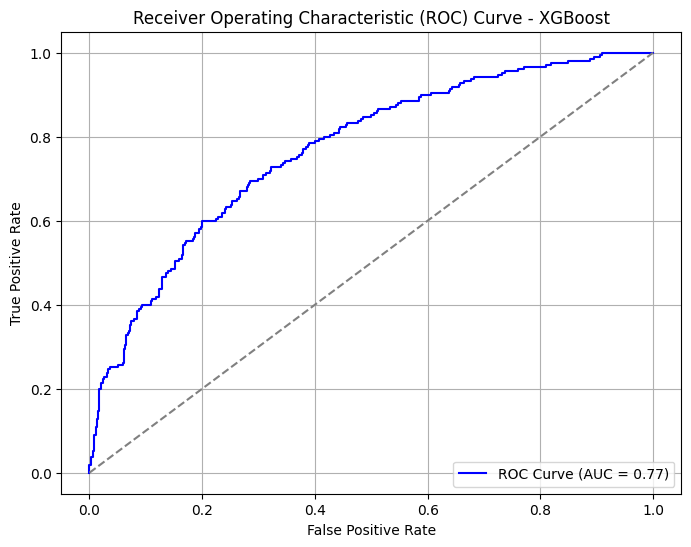

In [67]:
from sklearn.preprocessing import LabelEncoder

target = 'Doctor_Approved_High_BP_Yes'


features = df_encoded.drop(columns=[target, 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic', 'Avg_Diastolic_BP', 'Avg_Systolic_BP'])  # Dropping the target and unwanted columns


features = pd.get_dummies(features, drop_first=True)


label_encoder = LabelEncoder()
df_encoded[target] = label_encoder.fit_transform(df_encoded[target])


X_train, X_test, y_train, y_test = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


model_xgb = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


thresholds = np.linspace(0, 1, 100)


tpr_values = []
accuracy_values = []
roc_auc_values = []


model_xgb.fit(X_train, y_train)
y_prob_baseline = model_xgb.predict_proba(X_train)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.5).astype(int)
baseline_accuracy = accuracy_score(y_train, y_pred_baseline)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for train_index, val_index in kf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    
    model_xgb.fit(X_train_cv, y_train_cv)
    
    
    y_prob_cv = model_xgb.predict_proba(X_val_cv)[:, 1]
    
    
    best_threshold = 0.5
    best_accuracy = baseline_accuracy  # Ensuring baseline accuracy
    best_tpr = 0
    best_fpr = 1  # Worst possible, to be minimized
    
   
    for threshold in thresholds:
        y_pred_cv = (y_prob_cv >= threshold).astype(int)
        
        
        accuracy = accuracy_score(y_val_cv, y_pred_cv)
        tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred_cv).ravel()
        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate
        
        
        if accuracy >= baseline_accuracy and tpr > best_tpr:
            best_threshold = threshold
            best_accuracy = accuracy
            best_tpr = tpr
            best_fpr = fpr

    
    tpr_values.append(best_tpr)
    accuracy_values.append(best_accuracy)
    roc_auc_values.append(roc_auc_score(y_val_cv, y_prob_cv))


avg_tpr = np.mean(tpr_values)
avg_accuracy = np.mean(accuracy_values)
avg_roc_auc = np.mean(roc_auc_values)

print(f"Average TPR across folds: {avg_tpr:.4f}")
print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
print(f"Average ROC AUC across folds: {avg_roc_auc:.4f}")

model_xgb.fit(X_train, y_train)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]


y_pred_optimal = (y_prob_xgb >= best_threshold).astype(int)


conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = conf_matrix_optimal.ravel()
tpr_optimal = tp / (tp + fn)
fpr_optimal = fp / (fp + tn)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)

print(f"Optimal Threshold (from CV): {best_threshold:.4f}")
print(f"Accuracy on Test Set at Optimal Threshold: {accuracy_optimal:.4f}")
print(f"True Positive Rate (TPR) on Test Set at Optimal Threshold: {tpr_optimal:.4f}")
print(f"False Positive Rate (FPR) on Test Set at Optimal Threshold: {fpr_optimal:.4f}")
print(f"Confusion Matrix on Test Set at Optimal Threshold:\n{conf_matrix_optimal}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_optimal)}")
print(f"ROC AUC Score on Test Set: {roc_auc_score(y_test, y_prob_xgb):.4f}")


fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Combined ROC AUC curve for Predicting BP

C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Vaishali Senthil\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


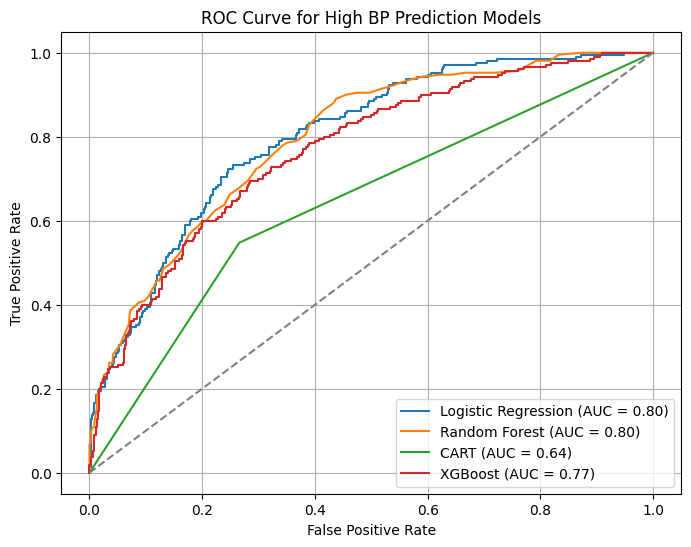

In [70]:

target = 'Doctor_Approved_High_BP_Yes'


features = df_encoded.drop(columns=[target, 'Total_Cholesterol', 
                                   'US_Citizen_Refused', 'Doctor_Reported_High_Cholesterol_No', 'Doctor_Approved_High_BP_No', 
                                   'Marital_Status_Living with Partner', 'Highest_Degree_Obtained_Don’t Know',
                                 'Race_Category_3_Other Hispanic', 'Avg_Diastolic_BP', 'Avg_Systolic_BP'])  # Dropping the target and unwanted columns


features = pd.get_dummies(features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(features, df_encoded[target], test_size=0.2, random_state=42)


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'CART': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


roc_data = {}


for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    roc_auc = roc_auc_score(y_test, y_prob)  # ROC AUC score
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # ROC curve data
    
    
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}


plt.figure(figsize=(8, 6))

# Plot each model's ROC curve
for model_name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f'{model_name} (AUC = {data["roc_auc"]:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line

plt.title('ROC Curve for High BP Prediction Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()
